In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# now can import drive files as usual files with the path like
# /content/drive/My Drive/location_of_the_file

Mounted at /content/drive


#Setup code#

In [ ]:
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

DRIVE_INITIAL_PATH = r"/content/drive/My Drive/Data Mining"

OUR_PP_RECIPES_PATH = r"data/our_pp_recipes.csv"
OUR_PP_INTERACTIONS_PATH = r"data/our_pp_interactions.csv"

DATE_FORMAT = "%Y-%m-%d"
RAW_RECIPES_DATE_COLUMNS = ["submitted"]
RAW_INTERCATIONS_DATE_COLUMNS = ["date"]


def adapt_path_to_drive(original_path):
  return "/".join([DRIVE_INITIAL_PATH, original_path])

# for drive use
OUR_PP_RECIPES_PATH = adapt_path_to_drive(OUR_PP_RECIPES_PATH)
OUR_PP_INTERACTIONS_PATH = adapt_path_to_drive(OUR_PP_INTERACTIONS_PATH)


In [ ]:
def format_date_column(df, column_to_format, date_format=DATE_FORMAT):
  df[column_to_format] = pd.to_datetime(df[column_to_format], format=date_format)
  return df

In [ ]:
DF_RECIPES = pd.read_csv(OUR_PP_RECIPES_PATH, encoding="utf-8")
DF_INTERACTIONS = pd.read_csv(OUR_PP_INTERACTIONS_PATH, encoding="utf-8")

In [ ]:
def get_year_month_counts(df, date_col):
  df = format_date_column(df, date_col) 
  df["year-month"] = df[date_col].dt.year.astype("str") + "-" + df[date_col].dt.month.apply(lambda x: '{:02}'.format(x))
  counts_df = df.groupby("year-month").count()["recipe_id"].reset_index()
  return counts_df.rename(columns={"recipe_id":"total_per_month"})

ALL_RECIPES_PER_MONTH = get_year_month_counts(DF_RECIPES, "submitted")


def show_bool_analyzed_submitted_graphs(col_name, parameter_desc, linewidth=1.5, lim_percent=(0, 1), marker=False):
  questioned_per_month = get_year_month_counts(DF_RECIPES.loc[DF_RECIPES[col_name]], "submitted")
  per_month_stats = ALL_RECIPES_PER_MONTH.merge(questioned_per_month, how="left",
                                              on="year-month",suffixes=("_all", "_questioned"))
  per_month_stats = per_month_stats.fillna(0)
  per_month_stats["questioned_per_month_percentage"] = per_month_stats["total_per_month_questioned"] / per_month_stats["total_per_month_all"]
  per_month_stats["start_month_date"] = per_month_stats["year-month"].apply(lambda x: x + "-01")
  per_month_stats = format_date_column(per_month_stats, "start_month_date")


  if marker:
    plt.plot_date(x=per_month_stats["start_month_date"], y=per_month_stats["total_per_month_questioned"], linestyle='solid', linewidth=linewidth, marker=True)
  else:
    plt.plot_date(x=per_month_stats["start_month_date"], y=per_month_stats["total_per_month_questioned"], linestyle='solid', linewidth=linewidth)

  plt.title('{0} submitted per month'.format(parameter_desc))
  plt.xlabel("submitted date")
  plt.ylabel("recipes amount")

  plt.show()


  if marker:
    plt.plot_date(x=per_month_stats["start_month_date"], y=per_month_stats["questioned_per_month_percentage"], linestyle="solid", linewidth=linewidth, marker=True)
  else:
    plt.plot_date(x=per_month_stats["start_month_date"], y=per_month_stats["questioned_per_month_percentage"], linestyle="solid", linewidth=linewidth)

  plt.xlabel("submitted date")
  plt.ylabel("relative portion out of submitted recipes")
  plt.title('{0} relative portion out of total submitted recipes per month'.format(parameter_desc))
  plt.ylim(lim_percent[0], lim_percent[1])

  plt.show()


In [ ]:
ALL_INTERACTIONS_PER_MONTH = get_year_month_counts(DF_INTERACTIONS, "date")


def show_bool_analyzed_interactions_graphs(col_name, parameter_desc, linewidth=1.5, lim_percent=(0, 1), marker=False):
  questioned_interactions = DF_RECIPES.loc[DF_RECIPES[col_name]].merge(DF_INTERACTIONS, how="inner", on="recipe_id")
  questioned_per_month = get_year_month_counts(questioned_interactions, "date")
  per_month_stats = ALL_INTERACTIONS_PER_MONTH.merge(questioned_per_month, how="left",
                                              on="year-month",suffixes=("_all", "_questioned"))
  per_month_stats = per_month_stats.fillna(0)
  per_month_stats["questioned_per_month_percentage"] = per_month_stats["total_per_month_questioned"] / per_month_stats["total_per_month_all"]
  per_month_stats["start_month_date"] = per_month_stats["year-month"].apply(lambda x: x + "-01")
  per_month_stats = format_date_column(per_month_stats, "start_month_date")


  if marker:
    plt.plot_date(x=per_month_stats["start_month_date"], y=per_month_stats["total_per_month_questioned"], linestyle='solid', linewidth=linewidth, marker=True)
  else:
    plt.plot_date(x=per_month_stats["start_month_date"], y=per_month_stats["total_per_month_questioned"], linestyle='solid', linewidth=linewidth)

  plt.title('interactions made with {0} per month'.format(parameter_desc))
  plt.xlabel("interactions date")
  plt.ylabel("interactions amount")

  plt.show()


  if marker:
    plt.plot_date(x=per_month_stats["start_month_date"], y=per_month_stats["questioned_per_month_percentage"], linestyle='solid', linewidth=linewidth, marker=True)
  else:
    plt.plot_date(x=per_month_stats["start_month_date"], y=per_month_stats["questioned_per_month_percentage"], linestyle='solid', linewidth=linewidth)

  plt.xlabel("interactions date")
  plt.ylabel("relative portion of submitted recipes")
  plt.title("{0}'s interactions relative portion out of total interactions made per month".format(parameter_desc))
  plt.ylim(lim_percent[0], lim_percent[1])

  plt.show()


In [ ]:
# get df and name of number column
# get steps_size, steps_amount - cur_min <= x < cur_max except the last which is cur_min <= x <= cur_max
# divide the data to steps_amount dfs - save in a map - key is the name of the range, value is the df
# run a version of show_analyzed_submitted_graphs that runs in bulks
# choose colors and make legend

def get_field_partition(df, col_name, min_value, step_size, steps_amount):
  d = {}
  col_series = df[col_name]
  for i in range(steps_amount):
    cur_min = min_value + i * step_size
    cur_max = cur_min + step_size
    cur_key = str(cur_min) + "-" + str(cur_max)
    if i == steps_amount - 1:
      cur_val = df.loc[(cur_min <= col_series) & (col_series <= cur_max)]
    else:
      cur_val = df.loc[(cur_min <= col_series) & (col_series < cur_max)]
    d[cur_key] = cur_val
  return d

def get_year_month_counts(df, date_col, counts_col_name="total_per_month"):
  df = format_date_column(df, date_col) 
  df["year-month"] = df[date_col].dt.year.astype("str") + "-" + df[date_col].dt.month.apply(lambda x: '{:02}'.format(x))
  counts_df = df.groupby("year-month").count()["recipe_id"].reset_index()
  return counts_df.rename(columns={"recipe_id":counts_col_name})

def get_per_month_stats(filtered_df, date_col_name, all_per_month_stats):
  questioned_per_month = get_year_month_counts(filtered_df, date_col_name)
  per_month_stats = all_per_month_stats.merge(questioned_per_month, how="left",
                                                on="year-month",suffixes=("_all", "_questioned"))
  per_month_stats = per_month_stats.fillna(0)
  per_month_stats["questioned_per_month_percentage"] = per_month_stats["total_per_month_questioned"] / per_month_stats["total_per_month_all"]
  per_month_stats["start_month_date"] = per_month_stats["year-month"].apply(lambda x: x + "-01")
  per_month_stats = format_date_column(per_month_stats, "start_month_date")
  return per_month_stats





In [ ]:
PP_RECIPES_DF = pd.read_csv(OUR_PP_RECIPES_PATH, encoding="utf-8")
PP_INTERACTIONS_DF = pd.read_csv(OUR_PP_INTERACTIONS_PATH, encoding="utf-8")
ALL_RECIPES_PER_MONTH = get_year_month_counts(PP_RECIPES_DF, "submitted")
ALL_INTERACTIONS_PER_MONTH = get_year_month_counts(PP_INTERACTIONS_DF, "date")



In [ ]:
def show_num_analyzed_submitted_graphs(df, col_name, parameter_desc, min_value, step_size, steps_amount,
                                       linewidth=1.5, lim_percent=(0, 1), marker=False):
  dfs_dicts = get_field_partition(df, col_name, min_value, step_size, steps_amount)
  questioned_dfs_per_month = {}
  colormap = plt.cm.viridis
  colors = [colormap(i) for i in np.linspace(0, 1,len(dfs_dicts))]

  for cur_key in dfs_dicts.keys():
    per_month_stats = get_per_month_stats(dfs_dicts[cur_key], "submitted", ALL_RECIPES_PER_MONTH)
    questioned_dfs_per_month[cur_key] = per_month_stats
  
  for (i ,cur_key) in enumerate(questioned_dfs_per_month.keys()):
    per_month_stats = questioned_dfs_per_month[cur_key]
    if marker:
      plt.plot_date(x=per_month_stats["start_month_date"], y=per_month_stats["total_per_month_questioned"], linestyle='solid', color=colors[i], label=cur_key, marker=True, linewidth=linewidth)
    else:
      plt.plot_date(x=per_month_stats["start_month_date"], y=per_month_stats["total_per_month_questioned"], linestyle='solid', color=colors[i], label=cur_key, linewidth=linewidth)
  

  plt.title('{0} submitted per month'.format(parameter_desc))
  plt.xlabel("submitted date")
  plt.ylabel("recipes amount")
  plt.legend()

  plt.show()

  for (i, cur_key) in enumerate(questioned_dfs_per_month.keys()):
    per_month_stats = questioned_dfs_per_month[cur_key]
    if marker:
      plt.plot_date(x=per_month_stats["start_month_date"], y=per_month_stats["questioned_per_month_percentage"], linestyle="solid", color=colors[i], label=cur_key, linewidth=linewidth, marker=True)
    else:
      plt.plot_date(x=per_month_stats["start_month_date"], y=per_month_stats["questioned_per_month_percentage"], linestyle="solid", color=colors[i], label=cur_key, linewidth=linewidth)


  plt.xlabel("submitted date")
  plt.ylabel("relative portion out of submitted recipes")
  plt.title('{0} relative portion out of total submitted recipes per month'.format(parameter_desc))
  plt.ylim(lim_percent[0], lim_percent[1])
  plt.legend()

  plt.show()


In [ ]:
                                     
def show_num_analyzed_interactions_graphs(df, col_name, parameter_desc, min_value, step_size, steps_amount,
                                          linewidth=1.5, lim_percent=(0, 1), marker=False):
  dfs_dicts = get_field_partition(df, col_name, min_value, step_size, steps_amount)
  questioned_dfs_per_month = {}
  colormap = plt.cm.viridis
  colors = [colormap(i) for i in np.linspace(0, 1,len(dfs_dicts))]

  for cur_key in dfs_dicts.keys():
    cur_df = dfs_dicts[cur_key].merge(PP_INTERACTIONS_DF, how="inner", on="recipe_id")
    per_month_stats = get_per_month_stats(cur_df, "date", ALL_INTERACTIONS_PER_MONTH)
    questioned_dfs_per_month[cur_key] = per_month_stats
  
  for (i ,cur_key) in enumerate(questioned_dfs_per_month.keys()):
    per_month_stats = questioned_dfs_per_month[cur_key]
    if marker:
      plt.plot_date(x=per_month_stats["start_month_date"], y=per_month_stats["total_per_month_questioned"], linestyle='solid', color=colors[i], label=cur_key, marker=True, linewidth=linewidth)
    else:
      plt.plot_date(x=per_month_stats["start_month_date"], y=per_month_stats["total_per_month_questioned"], linestyle='solid', color=colors[i], label=cur_key, linewidth=linewidth)

  

  plt.title('interactions made with {0} per month'.format(parameter_desc))
  plt.xlabel("interactions date")
  plt.ylabel("interactions amount")
  plt.legend()
  plt.show()

  for (i, cur_key) in enumerate(questioned_dfs_per_month.keys()):
    per_month_stats = questioned_dfs_per_month[cur_key]
    if marker:
      plt.plot_date(x=per_month_stats["start_month_date"], y=per_month_stats["questioned_per_month_percentage"], linestyle='solid', color=colors[i], label=cur_key, marker=True, linewidth=linewidth)
    else:
      plt.plot_date(x=per_month_stats["start_month_date"], y=per_month_stats["questioned_per_month_percentage"], linestyle='solid', color=colors[i], label=cur_key, linewidth=linewidth)


  plt.xlabel("interactions date")
  plt.ylabel("relative portion of submitted recipes")
  plt.title("{0}'s interactions relative portion out of total interactions made per month".format(parameter_desc))
  plt.ylim(lim_percent[0], lim_percent[1])
  plt.legend()

  plt.show()


#Calories graphs

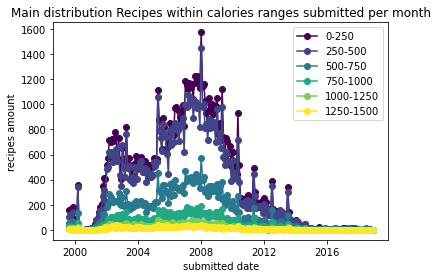

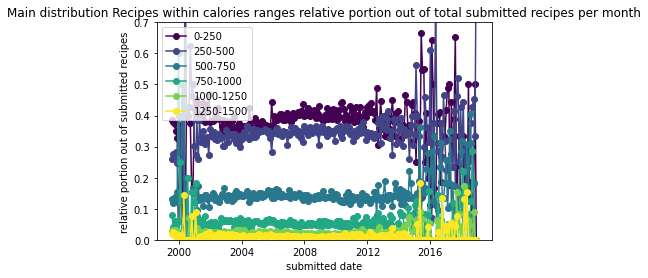

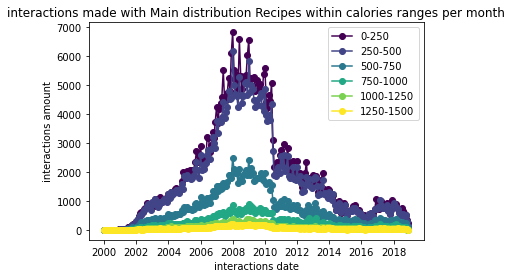

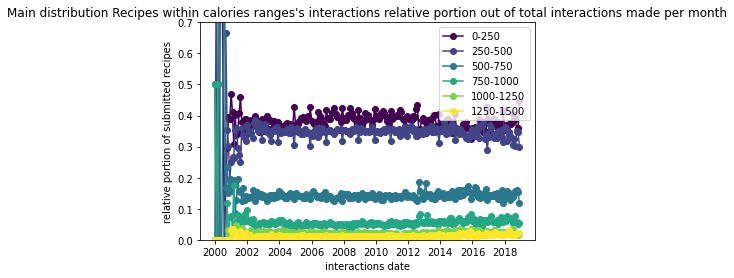

In [ ]:
show_num_analyzed_submitted_graphs(PP_RECIPES_DF, "calories", "Main distribution Recipes within calories ranges", 0, 250, 6,
                                       linewidth=1.5, lim_percent=(0, 0.7), marker=False)

show_num_analyzed_interactions_graphs(PP_RECIPES_DF, "calories", "Main distribution Recipes within calories ranges", 0, 250, 6,
                                          linewidth=1.5, lim_percent=(0, 0.7), marker=False)

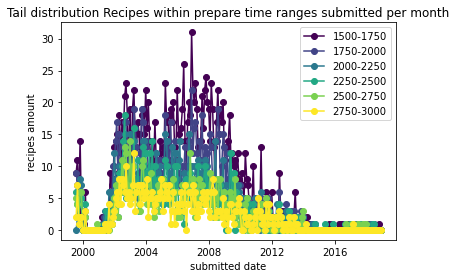

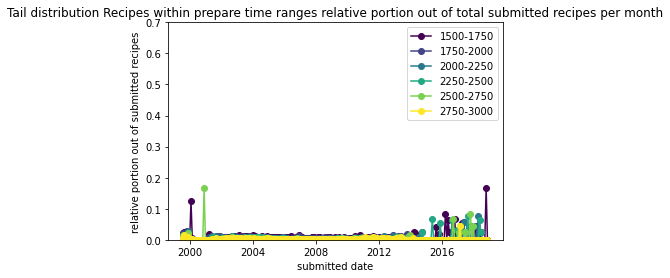

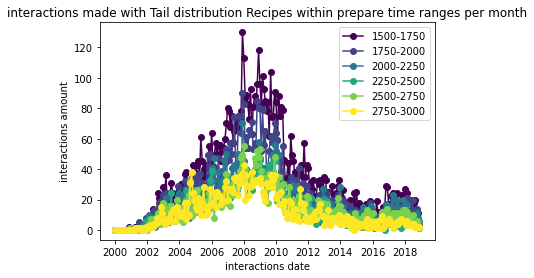

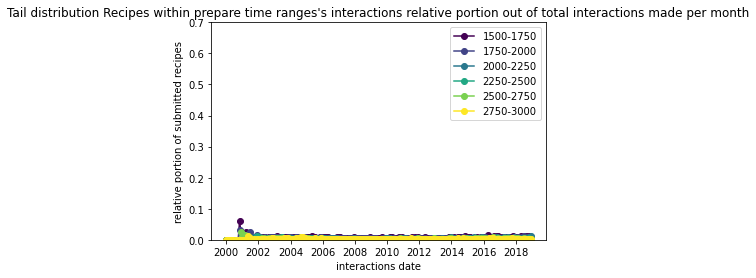

In [ ]:
show_num_analyzed_submitted_graphs(PP_RECIPES_DF, "calories", "Tail distribution Recipes within prepare time ranges", 1500, 250, 6,
                                       linewidth=1.5, lim_percent=(0, 0.7), marker=False)

show_num_analyzed_interactions_graphs(PP_RECIPES_DF, "calories", "Tail distribution Recipes within prepare time ranges", 1500, 250, 6,
                                          linewidth=1.5, lim_percent=(0, 0.7), marker=False)

#Total fat graphs

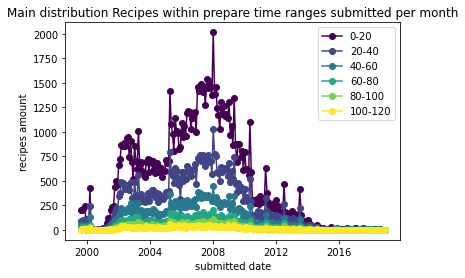

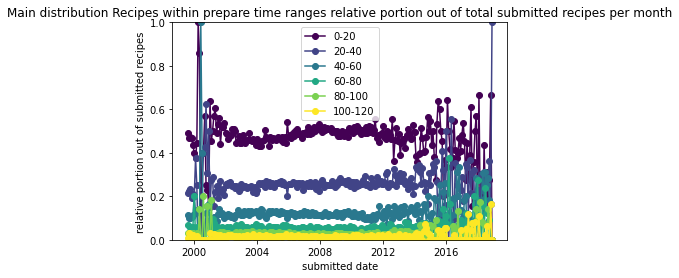

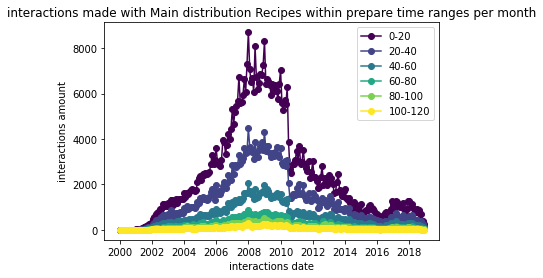

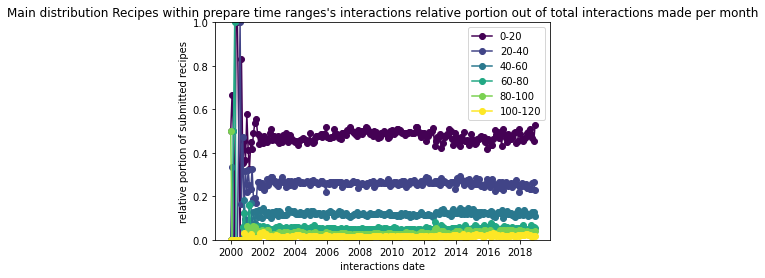

In [ ]:
show_num_analyzed_submitted_graphs(PP_RECIPES_DF, "total_fat_pdv", "Main distribution Recipes within prepare time ranges", 0, 20, 6,
                                       linewidth=1.5, lim_percent=(0, 1), marker=False)

show_num_analyzed_interactions_graphs(PP_RECIPES_DF, "total_fat_pdv", "Main distribution Recipes within prepare time ranges", 0, 20, 6,
                                          linewidth=1.5, lim_percent=(0, 1), marker=False)

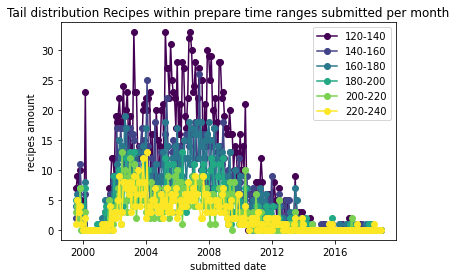

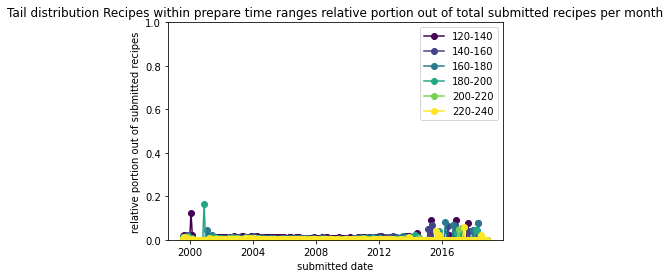

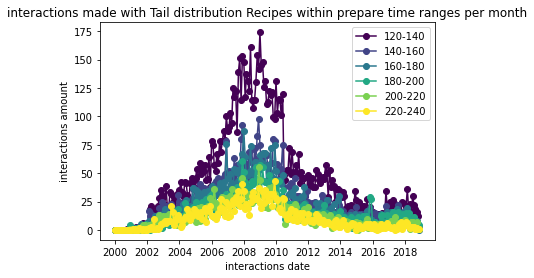

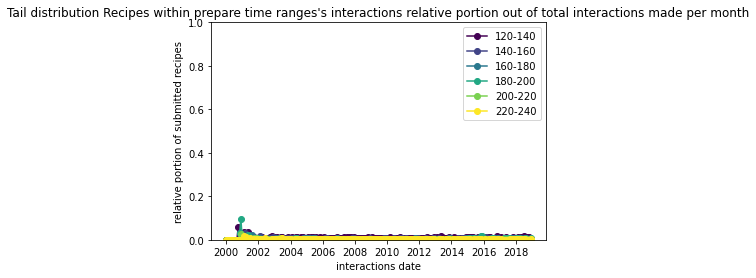

In [ ]:
show_num_analyzed_submitted_graphs(PP_RECIPES_DF, "total_fat_pdv", "Tail distribution Recipes within prepare time ranges", 120, 20, 6,
                                       linewidth=1.5, lim_percent=(0, 1), marker=False)

show_num_analyzed_interactions_graphs(PP_RECIPES_DF, "total_fat_pdv", "Tail distribution Recipes within prepare time ranges", 120, 20, 6,
                                          linewidth=1.5, lim_percent=(0, 1), marker=False)

#Sugar graphs

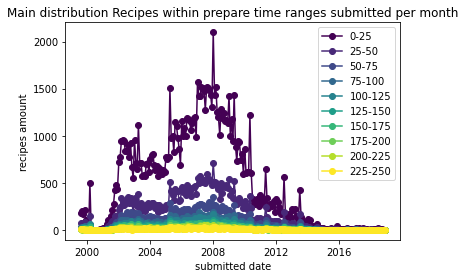

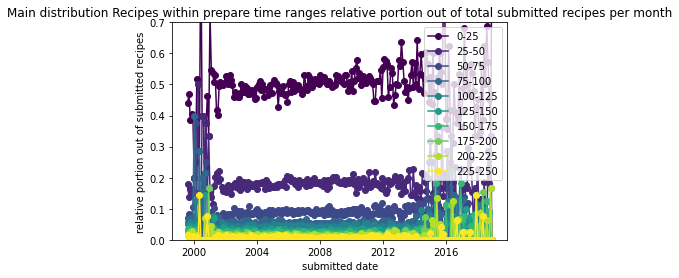

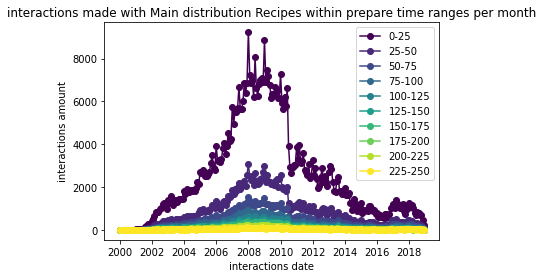

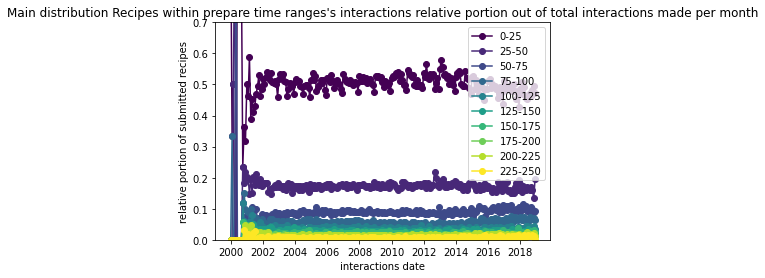

In [ ]:
show_num_analyzed_submitted_graphs(PP_RECIPES_DF, "sugar_pdv", "Main distribution Recipes within prepare time ranges", 0, 25, 10,
                                       linewidth=1.5, lim_percent=(0, 0.7), marker=False)

show_num_analyzed_interactions_graphs(PP_RECIPES_DF, "sugar_pdv", "Main distribution Recipes within prepare time ranges", 0, 25, 10,
                                          linewidth=1.5, lim_percent=(0, 0.7), marker=False)

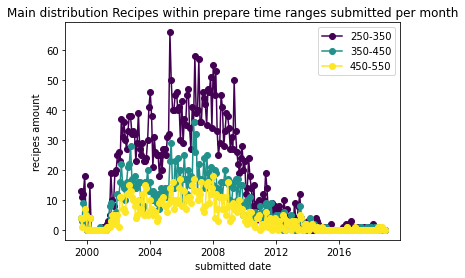

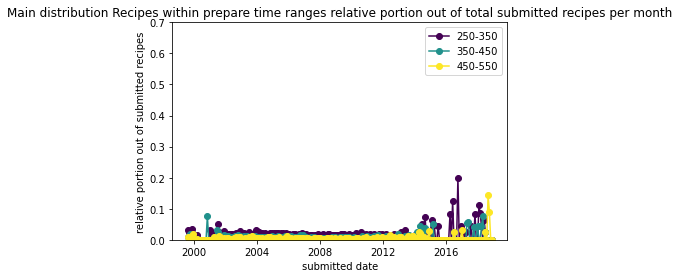

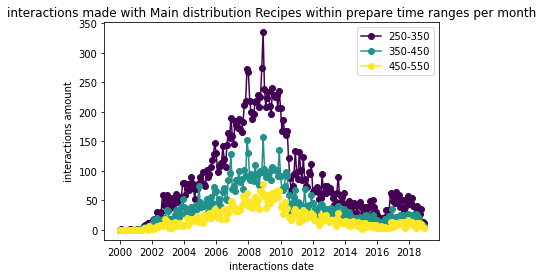

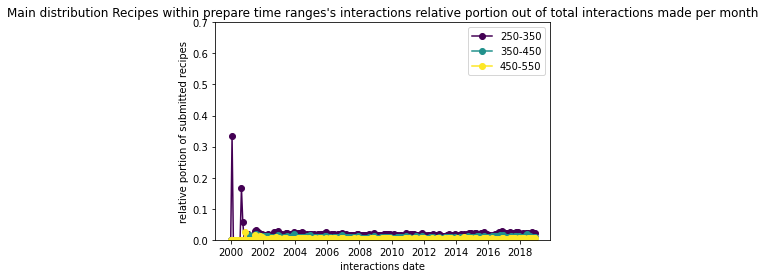

In [ ]:
show_num_analyzed_submitted_graphs(PP_RECIPES_DF, "sugar_pdv", "Main distribution Recipes within prepare time ranges", 250, 100, 3,
                                       linewidth=1.5, lim_percent=(0, 0.7), marker=False)

show_num_analyzed_interactions_graphs(PP_RECIPES_DF, "sugar_pdv", "Main distribution Recipes within prepare time ranges", 250, 100, 3,
                                          linewidth=1.5, lim_percent=(0, 0.7), marker=False)

#Sodium graphs

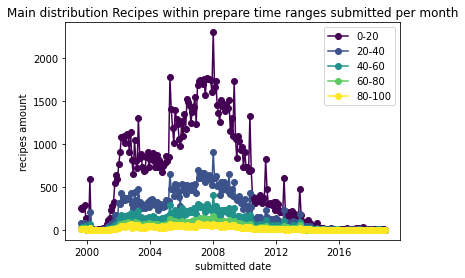

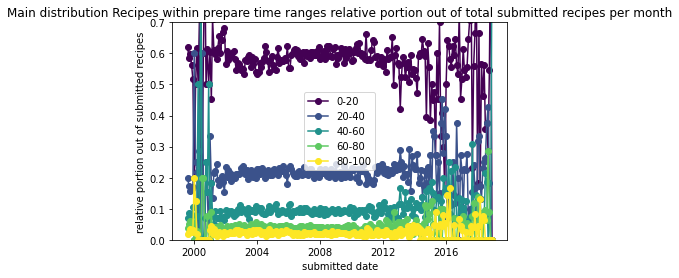

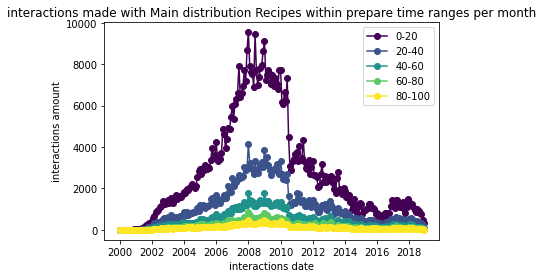

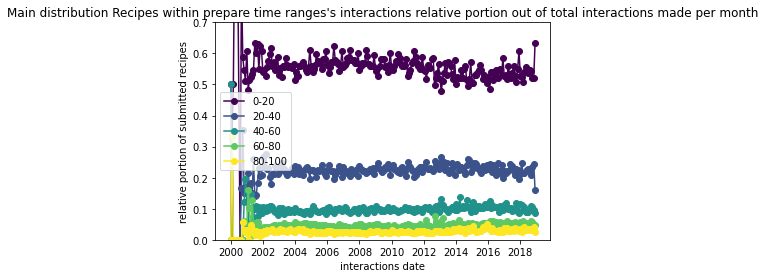

In [ ]:
show_num_analyzed_submitted_graphs(PP_RECIPES_DF, "sodium_pdv", "Main distribution Recipes within prepare time ranges", 0, 20, 5,
                                       linewidth=1.5, lim_percent=(0, 0.7), marker=False)

show_num_analyzed_interactions_graphs(PP_RECIPES_DF, "sodium_pdv", "Main distribution Recipes within prepare time ranges", 0, 20, 5,
                                          linewidth=1.5, lim_percent=(0, 0.7), marker=False)

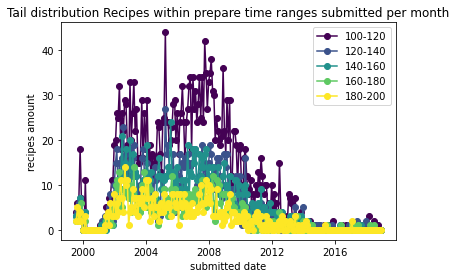

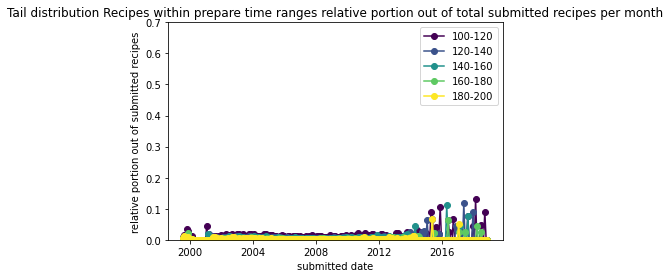

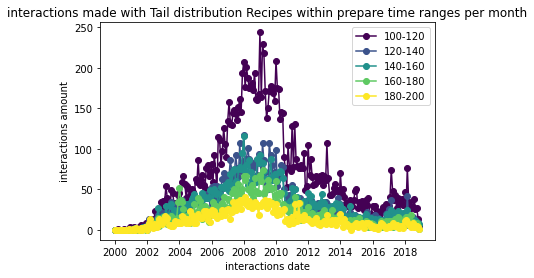

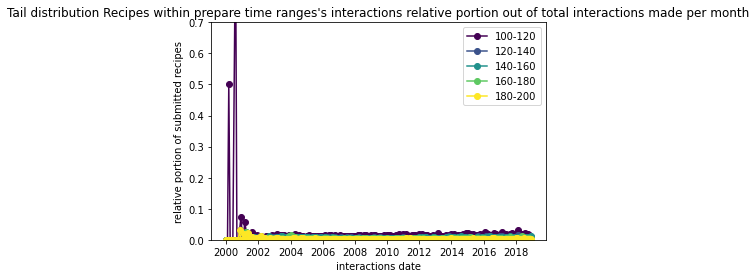

In [ ]:
show_num_analyzed_submitted_graphs(PP_RECIPES_DF, "sodium_pdv", "Tail distribution Recipes within prepare time ranges", 100, 20, 5,
                                       linewidth=1.5, lim_percent=(0, 0.7), marker=False)

show_num_analyzed_interactions_graphs(PP_RECIPES_DF, "sodium_pdv", "Tail distribution Recipes within prepare time ranges", 100, 20, 5,
                                          linewidth=1.5, lim_percent=(0, 0.7), marker=False)

#Protein graphs

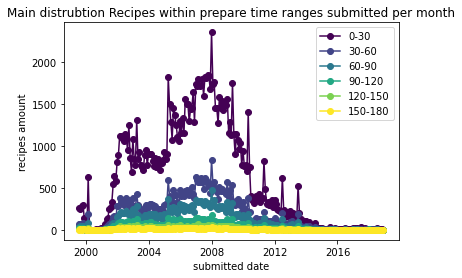

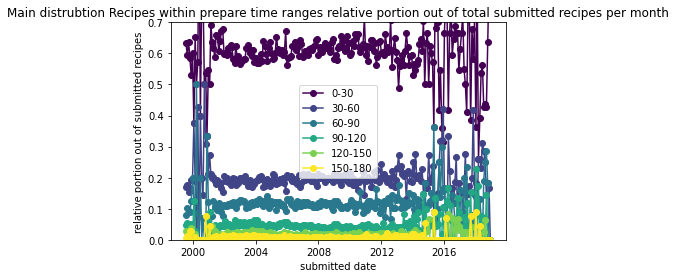

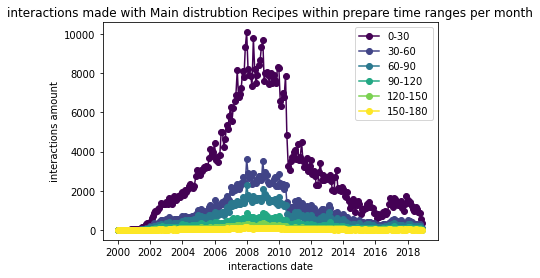

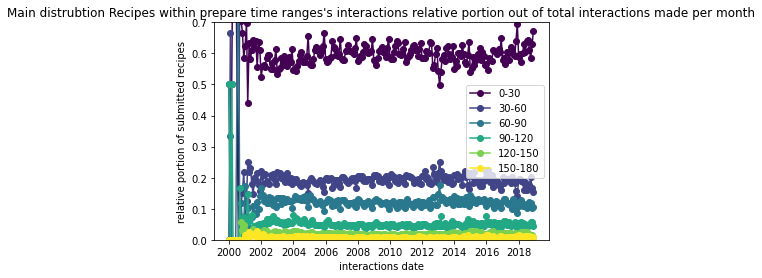

In [ ]:
show_num_analyzed_submitted_graphs(PP_RECIPES_DF, "protein_pdv", "Main distrubtion Recipes within prepare time ranges", 0, 30, 6,
                                       linewidth=1.5, lim_percent=(0, 0.7), marker=False)

show_num_analyzed_interactions_graphs(PP_RECIPES_DF, "protein_pdv", "Main distrubtion Recipes within prepare time ranges", 0, 30, 6,
                                          linewidth=1.5, lim_percent=(0, 0.7), marker=False)

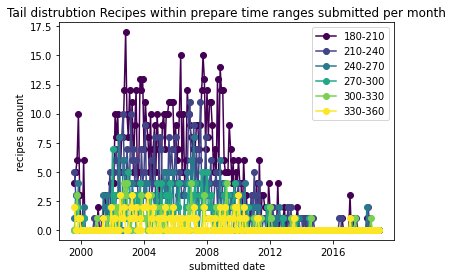

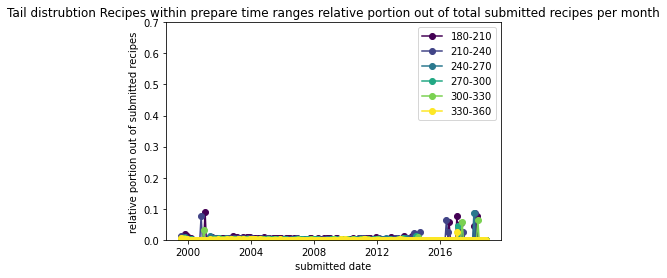

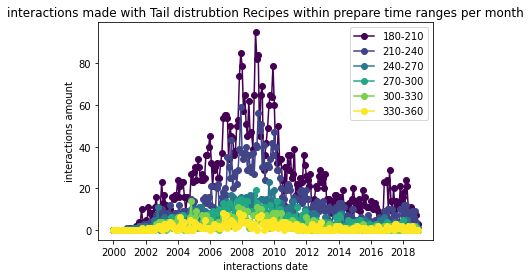

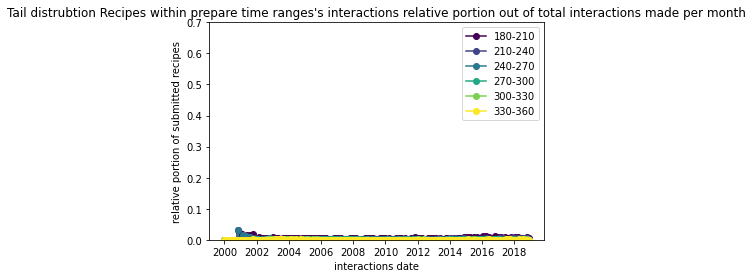

In [ ]:
show_num_analyzed_submitted_graphs(PP_RECIPES_DF, "protein_pdv", "Tail distrubtion Recipes within prepare time ranges", 180, 30, 6,
                                       linewidth=1.5, lim_percent=(0, 0.7), marker=False)

show_num_analyzed_interactions_graphs(PP_RECIPES_DF, "protein_pdv", "Tail distrubtion Recipes within prepare time ranges", 180, 30, 6,
                                          linewidth=1.5, lim_percent=(0, 0.7), marker=False)

# Saturated fat graphs

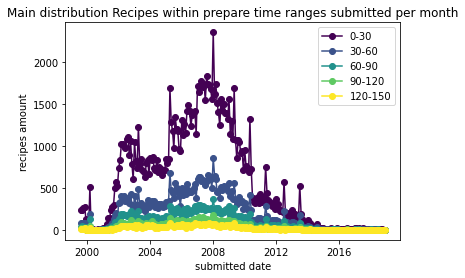

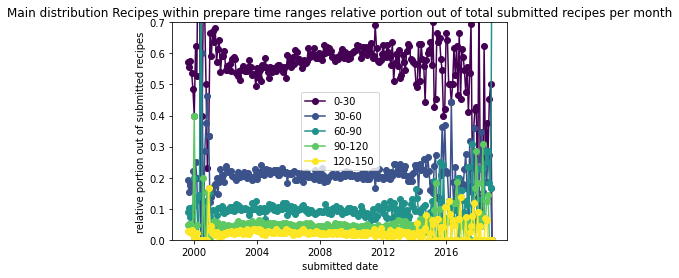

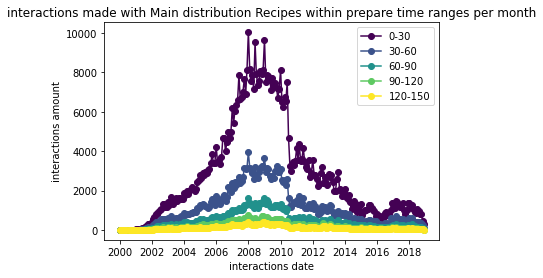

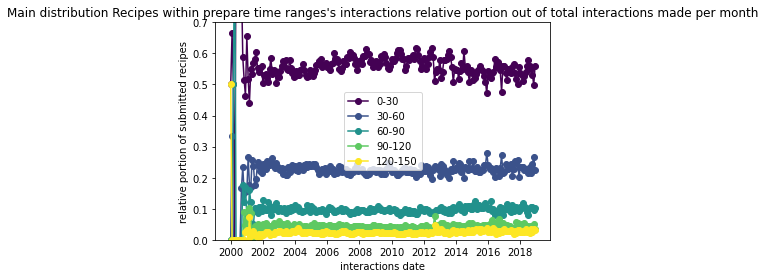

In [ ]:
show_num_analyzed_submitted_graphs(PP_RECIPES_DF, "saturated_fat_pdv", "Main distribution Recipes within prepare time ranges", 0, 30, 5,
                                       linewidth=1.5, lim_percent=(0, 0.7), marker=False)

show_num_analyzed_interactions_graphs(PP_RECIPES_DF, "saturated_fat_pdv", "Main distribution Recipes within prepare time ranges", 0, 30, 5,
                                          linewidth=1.5, lim_percent=(0, 0.7), marker=False)

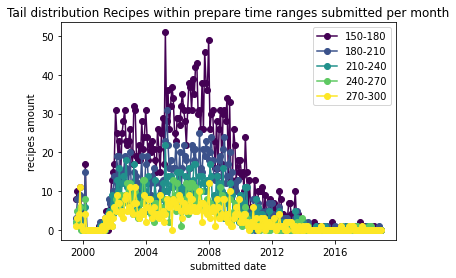

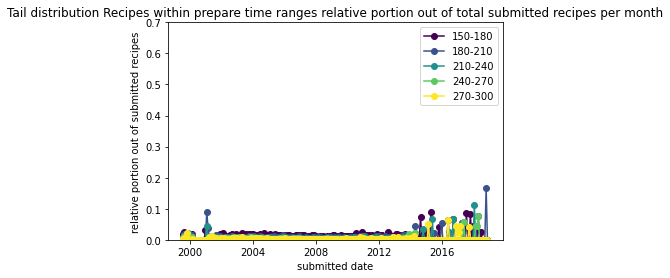

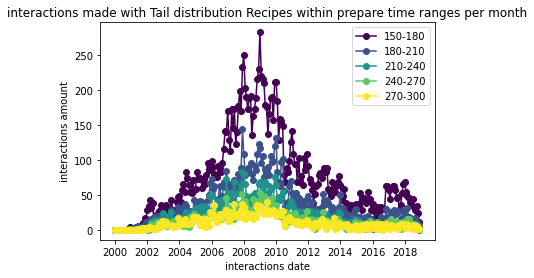

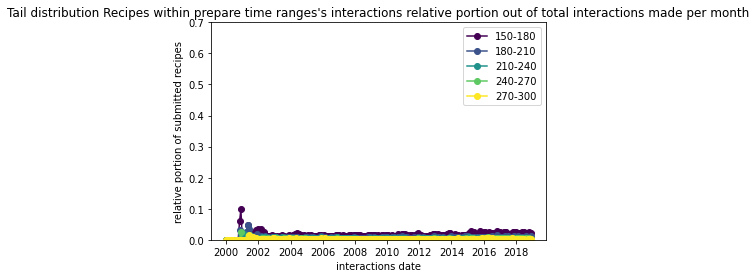

In [ ]:
show_num_analyzed_submitted_graphs(PP_RECIPES_DF, "saturated_fat_pdv", "Tail distribution Recipes within prepare time ranges", 150, 30, 5,
                                       linewidth=1.5, lim_percent=(0, 0.7), marker=False)

show_num_analyzed_interactions_graphs(PP_RECIPES_DF, "saturated_fat_pdv", "Tail distribution Recipes within prepare time ranges", 150, 30, 5,
                                          linewidth=1.5, lim_percent=(0, 0.7), marker=False)

#Carbohydrates graphs

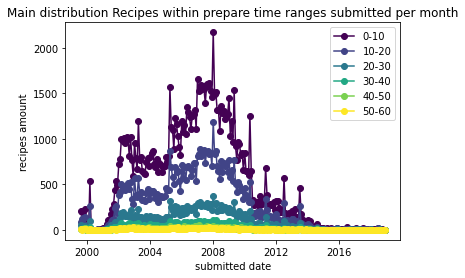

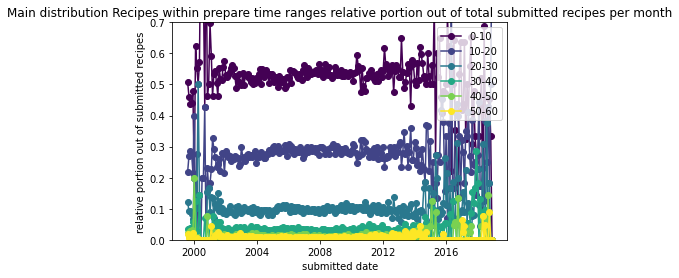

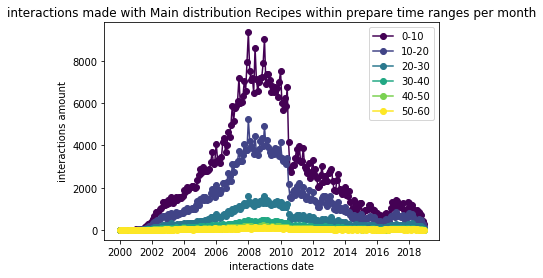

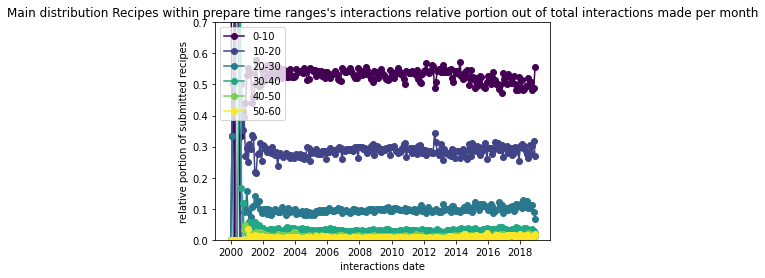

In [ ]:
show_num_analyzed_submitted_graphs(PP_RECIPES_DF, "carbohydrates_pdv", "Main distribution Recipes within prepare time ranges", 0, 10, 6,
                                       linewidth=1.5, lim_percent=(0, 0.7), marker=False)

show_num_analyzed_interactions_graphs(PP_RECIPES_DF, "carbohydrates_pdv", "Main distribution Recipes within prepare time ranges", 0, 10, 6,
                                          linewidth=1.5, lim_percent=(0, 0.7), marker=False)

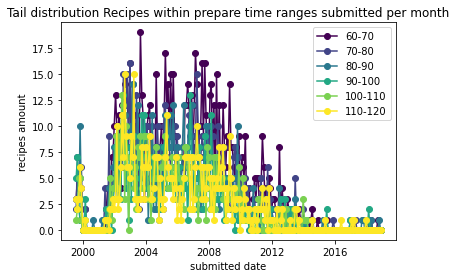

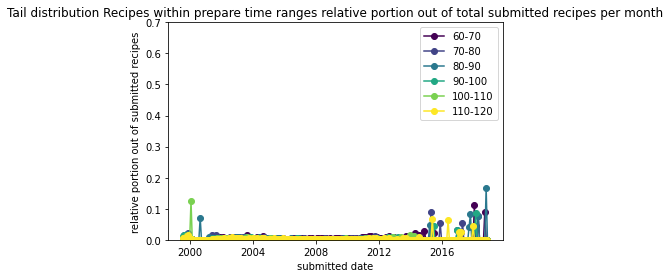

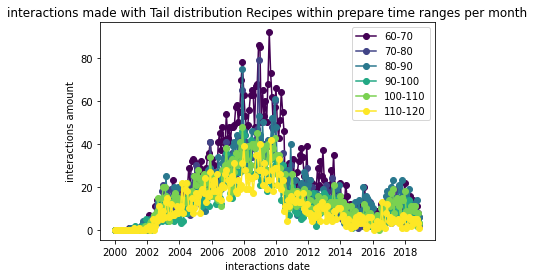

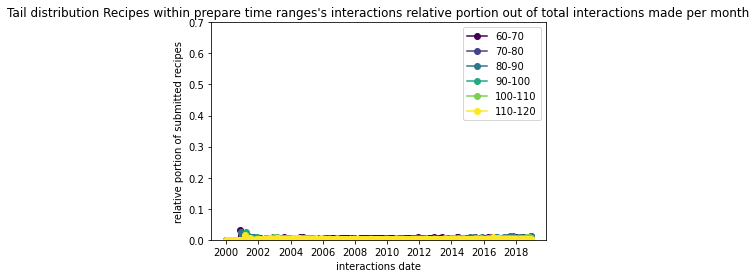

In [ ]:
show_num_analyzed_submitted_graphs(PP_RECIPES_DF, "carbohydrates_pdv", "Tail distribution Recipes within prepare time ranges", 60, 10, 6,
                                       linewidth=1.5, lim_percent=(0, 0.7), marker=False)

show_num_analyzed_interactions_graphs(PP_RECIPES_DF, "carbohydrates_pdv", "Tail distribution Recipes within prepare time ranges", 60, 10, 6,
                                          linewidth=1.5, lim_percent=(0, 0.7), marker=False)

#Is Vegetarian Tagged graphs#



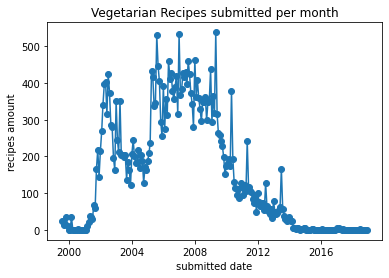

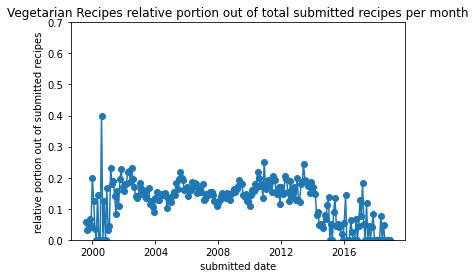

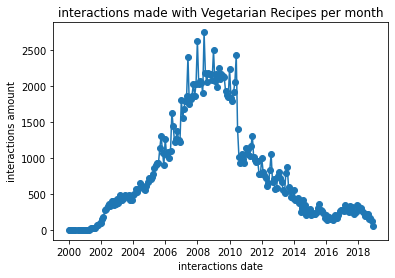

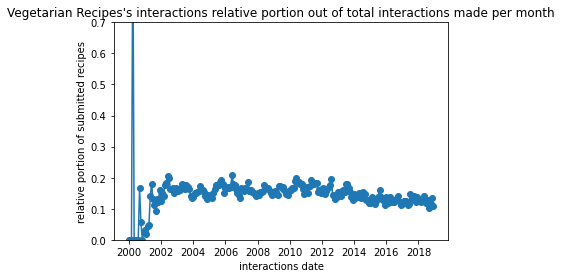

In [ ]:
show_bool_analyzed_submitted_graphs("is_vegetarian_tags", "Vegetarian Recipes",
                                       linewidth=1.5, lim_percent=(0, 0.7), marker=False)

show_bool_analyzed_interactions_graphs("is_vegetarian_tags", "Vegetarian Recipes",
                                          linewidth=1.5, lim_percent=(0, 0.7), marker=False)

#Is Vegan Tagged graphs#


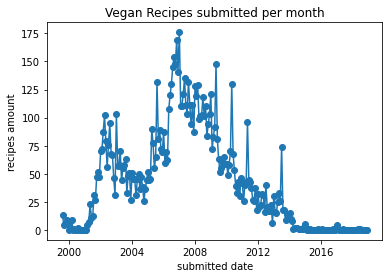

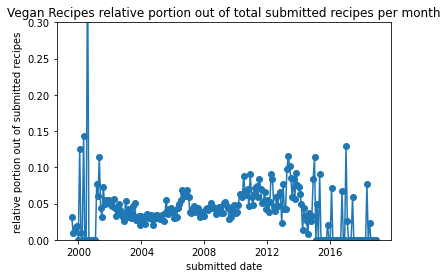

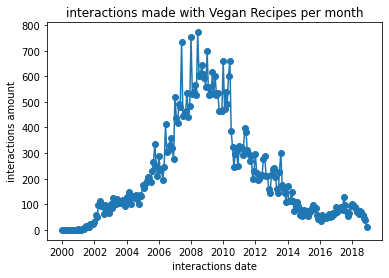

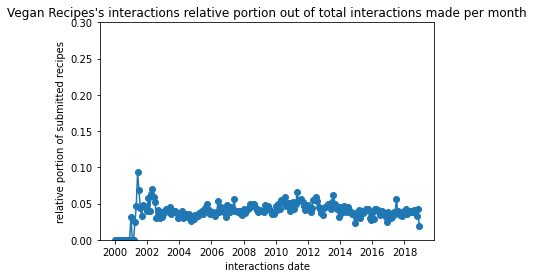

In [ ]:
show_bool_analyzed_submitted_graphs("is_vegan_tag", "Vegan Recipes",
                                       linewidth=1.5, lim_percent=(0, 0.3), marker=False)

show_bool_analyzed_interactions_graphs("is_vegan_tag", "Vegan Recipes",
                                          linewidth=1.5, lim_percent=(0, 0.3), marker=False)